### keep in mind you need to get no of active cases(confirmed-recovered-deceased)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/asgn1/'

Mounted at /content/gdrive


In [2]:
import json 
import pandas as pd
import numpy as np
import requests
import datetime
import scipy.signal as signal
import matplotlib.pyplot as plt

In [3]:
# to open json file
# /content/gdrive/MyDrive/asgn1/neighbor-districts-modified.json
f=open('/content/gdrive/MyDrive/asgn1/neighbor-districts-modified.json')
 # this function basically stores json type files into python dictionary
dist_modified=json.load(f)

In [4]:
district_list_from_json=[]
for key in dist_modified:
    district_list_from_json.append(key)
district_list_from_json=np.array(district_list_from_json)
district_list_from_json.sort()

state_district_codes=[]
for i in range(len(district_list_from_json)):
    state_district_codes.append(district_list_from_json[i].split('/')[1])

# district names - sample entry: churu
district_names_from_json=[] 

# district ids - sample entry: Q1090006
district_ids_from_json=[]

#use split() function and specify the separator '/' . Remember default seperator is whitspace
for i in range(len(district_list_from_json)):
    district_names_from_json.append(district_list_from_json[i].split("/")[0])
    district_ids_from_json.append(district_list_from_json[i].split("/")[1])

In [5]:
district_ids_list={}
for i in range(len(district_names_from_json)):
    district_ids_list[district_names_from_json[i]]=district_names_from_json[i] + '/' + district_ids_from_json[i]

In [6]:
# dictionaries for mapping dates to time ids
# eg. for 2020-3-15, time_id_week is 1, time_id_month is 1, time_id_ is 1

time_id_week = {}
time_id_month = {}
time_id_overall = {}

date=datetime.date(2020,3,15)
day=1
even_list=[]
odd_list=[]
for i in range(200):
    if (i+1)%2==0:
        even_list.append(i+1)
    else:
        odd_list.append(i+1)
while True:
    # basically to cover overlapping weeks this part needs to be changed.
    # for now we are proceeding. but change week ids according above definition of 7-DMA
    list_week=[0,1,2,6]
    if date.weekday() in list_week:
        time_id_week[str(date)]=odd_list[int(np.ceil(day/7))-1]
    else:
        time_id_week[str(date)]=even_list[int(np.ceil(day/7))-1]
        
    if str(date)[0:4]=='2020':
        if int(str(date)[8:10]) <15:
            time_id_month[str(date)]=int(str(date)[5:7])-3
        else:
            time_id_month[str(date)]=int(str(date)[5:7])-2
    else:
        if int(str(date)[8:10]) <15:
            time_id_month[str(date)]=int(str(date)[5:7])+9
        else:
            time_id_month[str(date)]=int(str(date)[5:7])+10

    time_id_overall[str(date)]=1
    
    if date==datetime.date(2021,8,14):
        break
    day=day+1
    date=date+datetime.timedelta(days=1)

In [7]:
data_csv=pd.read_csv('/content/gdrive/MyDrive/asgn1/districts.csv')
data_csv=data_csv.drop('Tested',axis=1)
data_csv.isnull().sum()

Date         0
State        0
District     0
Confirmed    0
Recovered    0
Deceased     0
Other        0
dtype: int64

In [8]:
data_csv=data_csv.sort_values(['District','Date'])
data_csv.reset_index(inplace=True,drop=True)
data_csv['District']=data_csv['District'].str.lower()

In [9]:
district_names_from_cases=[]
district_ids_from_cases=[]
district_uniques=np.array(np.unique(data_csv['District']))
for i in range(len(district_ids_list)):
    for j in range(len(district_uniques)):
        if district_uniques[j]==district_names_from_json[i]:
            district_ids_from_cases.append(district_ids_from_json[i])
            district_names_from_cases.append(district_uniques[j])
            break

In [10]:
data_csv['Active']=data_csv['Confirmed']-(data_csv['Deceased']+data_csv['Recovered'])

In [11]:
%%time
data_csv['Daily Cases']=np.nan
for i in range(len(district_names_from_cases)):
    foo_df = data_csv[data_csv['District']==district_names_from_cases[i]]
    foo_cases = foo_df.iloc[0,3]
    foo_df['Daily Cases']=foo_df['Active'].diff() # active ones
    foo_df.iloc[0,-1]=foo_cases
    data_csv.loc[data_csv['District']==district_names_from_cases[i],'Daily Cases']=foo_df['Daily Cases']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


CPU times: user 23.9 s, sys: 112 ms, total: 24.1 s
Wall time: 24.1 s


In [12]:
data_csv.isnull().sum()

Date               0
State              0
District           0
Confirmed          0
Recovered          0
Deceased           0
Other              0
Active             0
Daily Cases    17209
dtype: int64

In [13]:
data_csv.dropna(inplace=True)

In [14]:
data_csv.isnull().sum()

Date           0
State          0
District       0
Confirmed      0
Recovered      0
Deceased       0
Other          0
Active         0
Daily Cases    0
dtype: int64

In [15]:
dates_in_raw=np.unique(data_csv['Date']).tolist()

In [16]:
%%time
data_csv['Week ID']=np.nan
data_csv['Month ID']=np.nan
for date in time_id_week:
    if dates_in_raw.count(date)>0:
        data_csv.loc[data_csv['Date']==date,'Week ID']=time_id_week[date]
        data_csv.loc[data_csv['Date']==date,'Month ID']=time_id_month[date]

CPU times: user 19.4 s, sys: 130 ms, total: 19.5 s
Wall time: 19.6 s


In [17]:
data_csv.isnull().sum()

Date               0
State              0
District           0
Confirmed          0
Recovered          0
Deceased           0
Other              0
Active             0
Daily Cases        0
Week ID        11818
Month ID       11818
dtype: int64

In [18]:
data_csv.dropna(inplace=True)

In [19]:
data_csv.isnull().sum()

Date           0
State          0
District       0
Confirmed      0
Recovered      0
Deceased       0
Other          0
Active         0
Daily Cases    0
Week ID        0
Month ID       0
dtype: int64

In [20]:
%%time
# run it on your own risk it is too it might take 2-3 hours(don't know exact) hahaha
# will try to find another method that is fast enough
# no of weeks
# should take around 15 minutes
no_of_weeks=list(time_id_week.values())[-1]
districtid=[]
weekid=[]
cases=[]
active=[]
for i in range(len(district_names_from_cases)):
    for j in range(no_of_weeks):
        districtid.append(district_ids_from_cases[i])
        weekid.append(j+1)
        foo_df=data_csv[(data_csv['District']==district_names_from_cases[i]) & ((data_csv['Week ID']==j+1) | (data_csv['Week ID']==j+2))]
        cases.append(foo_df['Daily Cases'].sum())
        active.append(foo_df['Active'].sum())
            
week_df=pd.DataFrame({'districtid':districtid,'weekid':weekid,'cases':cases,'active':active})
week_df.to_csv('cases-week.csv',index=False) 

CPU times: user 29min 43s, sys: 20.7 s, total: 30min 4s
Wall time: 29min 40s


In [21]:
%%time
no_of_months=list(time_id_month.values())[-1]
districtid=[]
monthid=[]
cases=[]
active=[]
for i in range(len(district_names_from_cases)): # if delhi etc are not there just 
    for j in range(no_of_months):
        districtid.append(district_ids_from_cases[i])
        monthid.append(j+1)
        foo_df=data_csv[(data_csv['District']==district_names_from_cases[i]) & (data_csv['Month ID']==j+1)]
        cases.append(foo_df['Daily Cases'].sum())
        active.append(foo_df['Active'].astype(int).sum())
month_df=pd.DataFrame({'districtid':districtid,'monthid':monthid,'cases':cases,'active':active})
month_df.to_csv('cases-month.csv',index=False) 

CPU times: user 3min 11s, sys: 1.62 s, total: 3min 13s
Wall time: 3min 12s


### timseseries can be plotted

In [68]:
def choose_function(time_series,indices):
    indices=indices.tolist()
    foo_list=time_series[indices]
    ind1=indices[foo_list.argmax()]
    indices.remove(ind1)
    time_series[ind1]=0
    foo_list=time_series[indices]
    #foo_list.remove(time_series[ind1])
    ind2=indices[foo_list.argmax()]
    if ind2
    if ind1<ind2:
        return [ind1,ind2]
    else:
        return [ind2,ind1]

In [123]:
def choose_function(time_series,indices):
    indices=indices.tolist()
    foo_list=time_series[indices]
    max1=max(foo_list.tolist())
    ind1=indices[foo_list.argmax()]
    indices.remove(ind1)
    time_series[ind1]=-99999
    foo_list=time_series[indices]
    max2=max(foo_list.tolist())
    if max1==max2: # to cover the cases where value of  peaks is equal and that gives nearby peak1 and peak2 values
      ind_foo=indices[foo_list.argmax()]
      indices.remove(ind_foo)
      time_series[ind_foo]=-99999
      foo_list=time_series[indices]
      ind2=indices[foo_list.argmax()]
    else:
      ind2=indices[foo_list.argmax()]
### for cases like MN_Churachandpur
### where there is no recoed of cases
    if max1==0:
      ind1=40
      ind2=115
    if ind1<ind2:
        return [ind1,ind2]
    else:
        return [ind2,ind1]

In [127]:
np.unique(peak2,return_counts=True)
# it is quite possible that due to data discrepency we are having values like 140+ in peak2
#or should I consider active case cummulative values till that week last date that is also possible

(array([103, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132,
        134, 137, 138, 139, 140, 141, 143, 144, 146, 147]),
 array([ 1,  1,  2,  2,  1,  4,  8, 18, 33, 54, 92, 69, 56, 48, 54, 48, 21,
        19, 26, 16,  8,  4,  3,  4,  2,  1,  1,  2,  5,  3,  3,  1,  3,  1,
         1,  2]))

In [128]:
np.unique(peak1,return_counts=True)

(array([ 1, 12, 13, 15, 17, 18, 19, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 83, 86]),
 array([ 1,  2,  4,  1,  1,  1,  2,  2,  4,  1,  2,  1,  3,  4,  4,  2,  9,
        10,  8, 10, 25, 27, 19, 23, 20, 22, 14, 19, 11, 15, 28, 23, 35, 41,
        36, 30, 18, 11, 10, 17, 14,  7,  2,  7,  4,  5,  2,  3,  5,  4,  7,
         2,  7, 12,  7,  3,  2,  3,  1,  2,  1,  1]))

[  0   1   2  43 139]
[  0.   0.   0.  63. 211.]


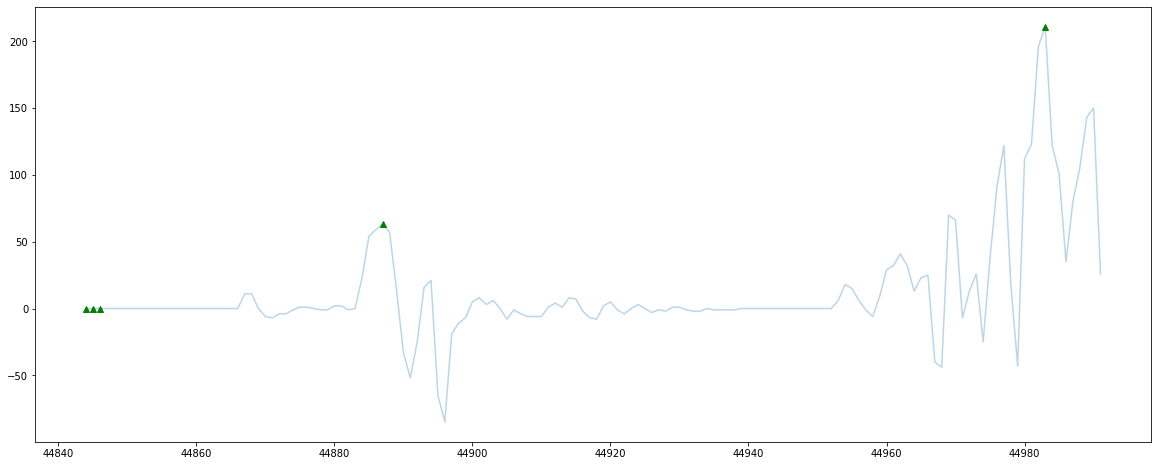

In [136]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(140)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[  0   1  23  53  75 140]
[  0.   0.  45.  42.  17. 428.]


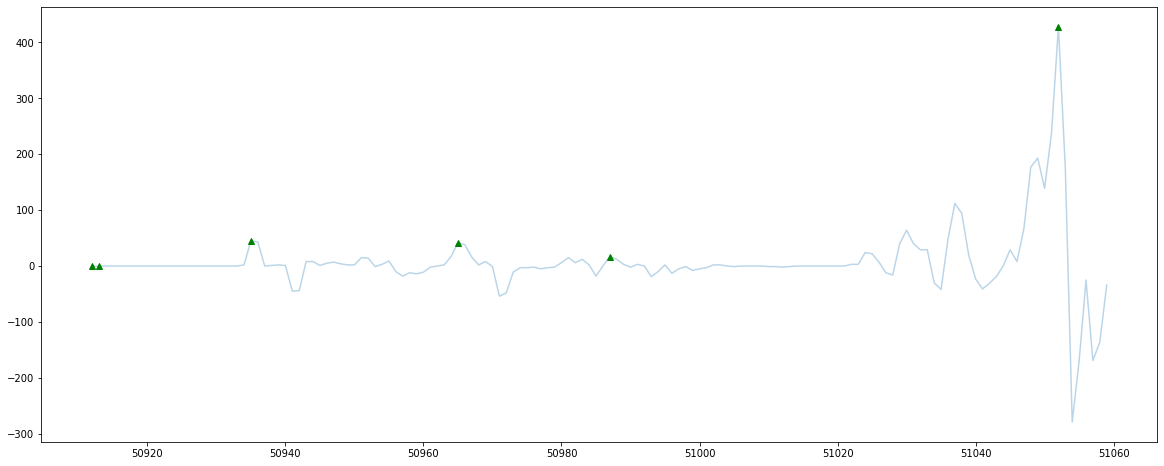

In [137]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(141)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[ 64 142]
[ 240. 3695.]


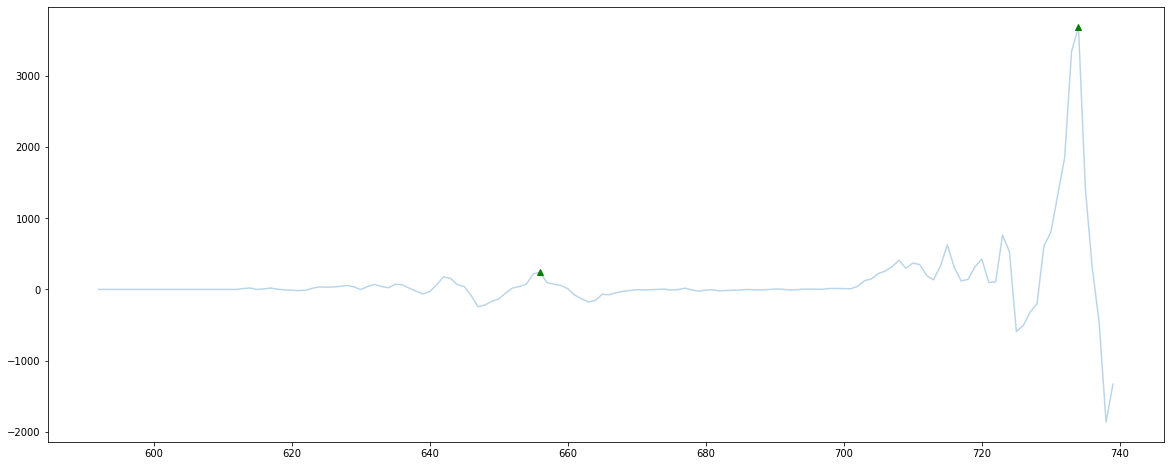

In [134]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(143)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[  0   1   2  30  71  72 118 143]
[ 0.  0.  0.  9.  2.  2. 40. 80.]


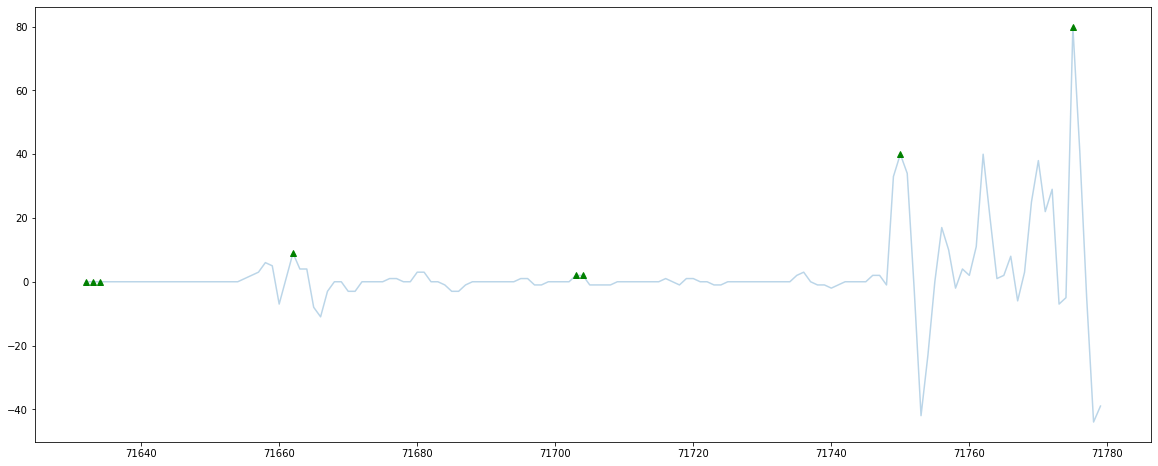

In [133]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(144)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[  0   1  30  70 145]
[  0.   0.  78. 142.  58.]


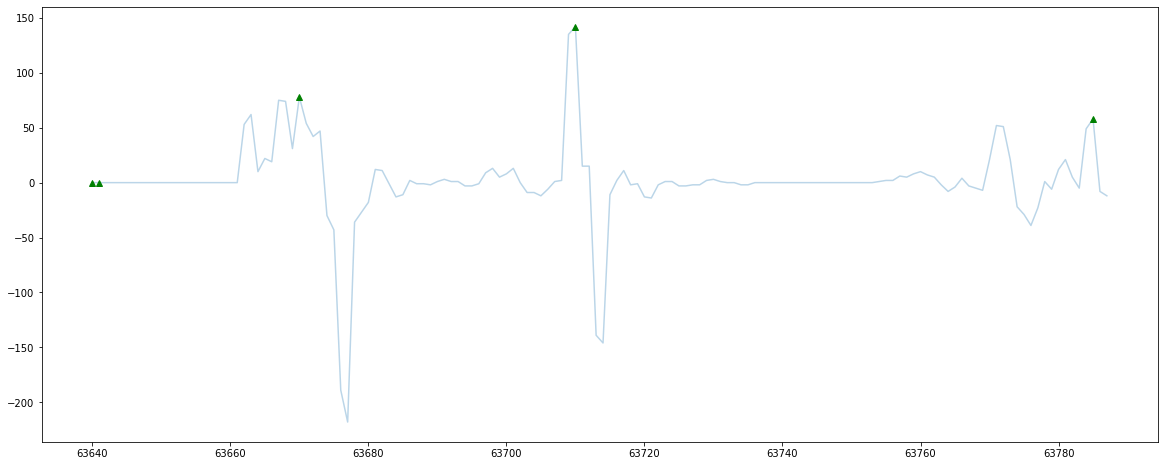

In [132]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(146)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''a
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

In [131]:
district_ids_from_cases[peak2.index(147)]

'MZ_Champhai'

[  0   1   2  23  24  66 146]
[  0.   0.   0.   5.   5.  36. 107.]


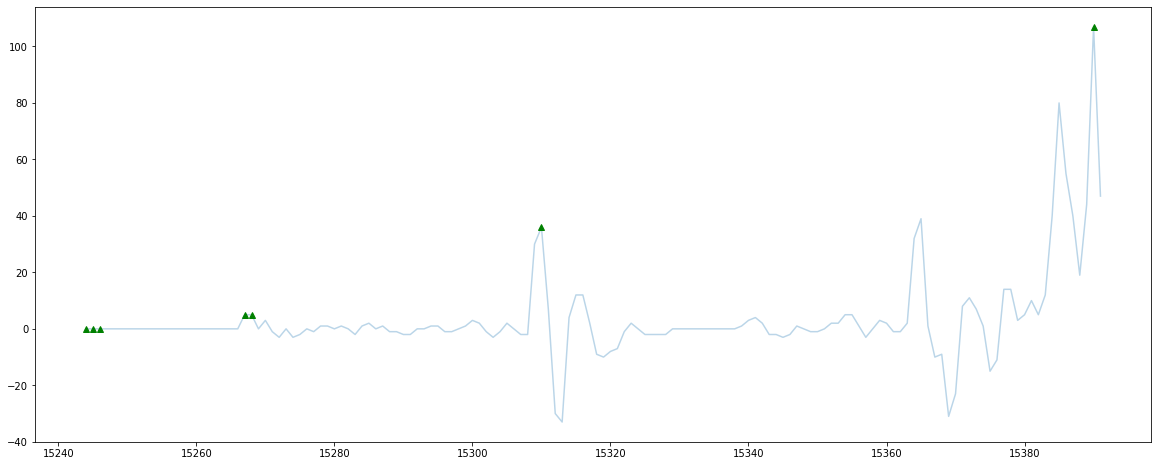

In [130]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(147)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[ 85 115 146]
[1005. 4842.  753.]


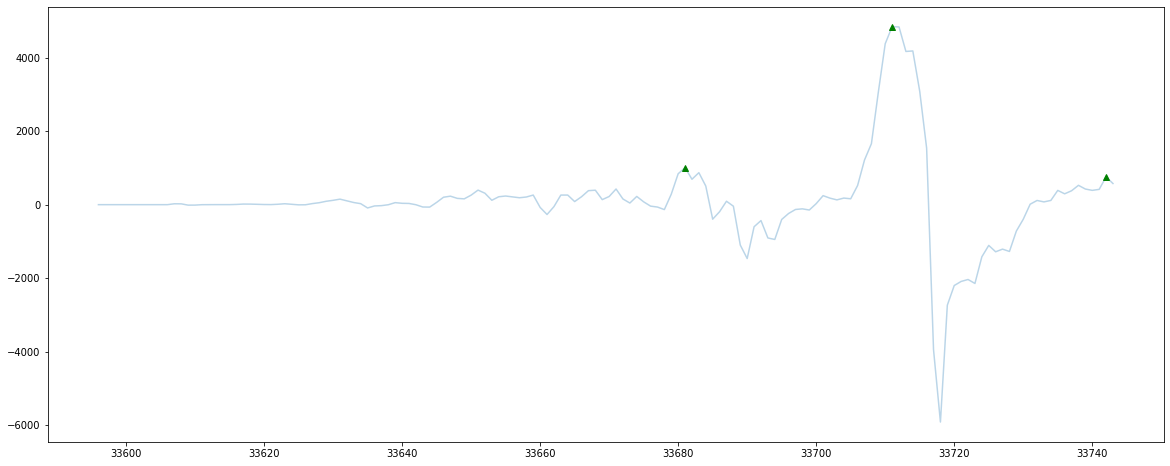

In [110]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak1.index(86)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

In [124]:
district_ids_from_cases[peak2.index(3)]

'MN_Churachandpur'

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

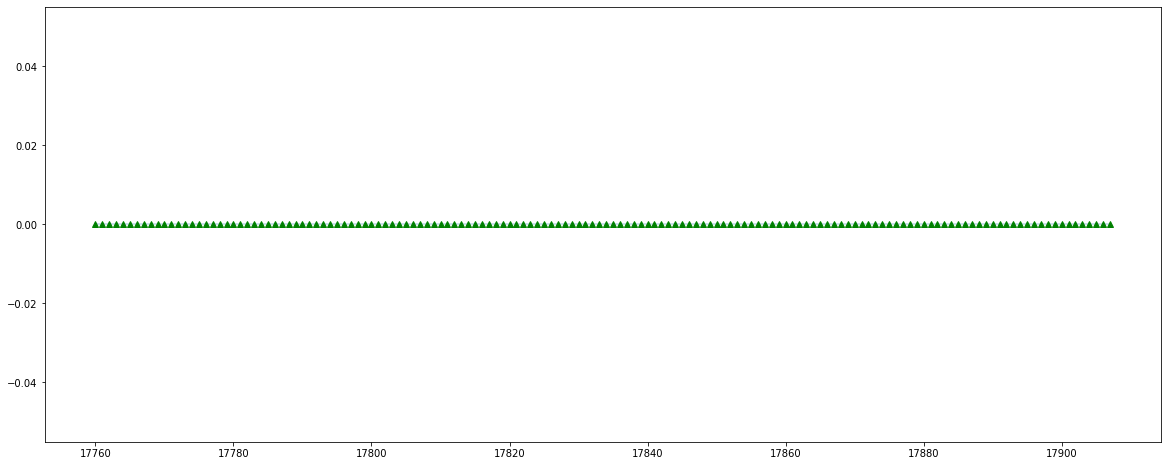

In [129]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']=='MN_Churachandpur']
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[ 82 115 146]
[1416. 4768.  665.]


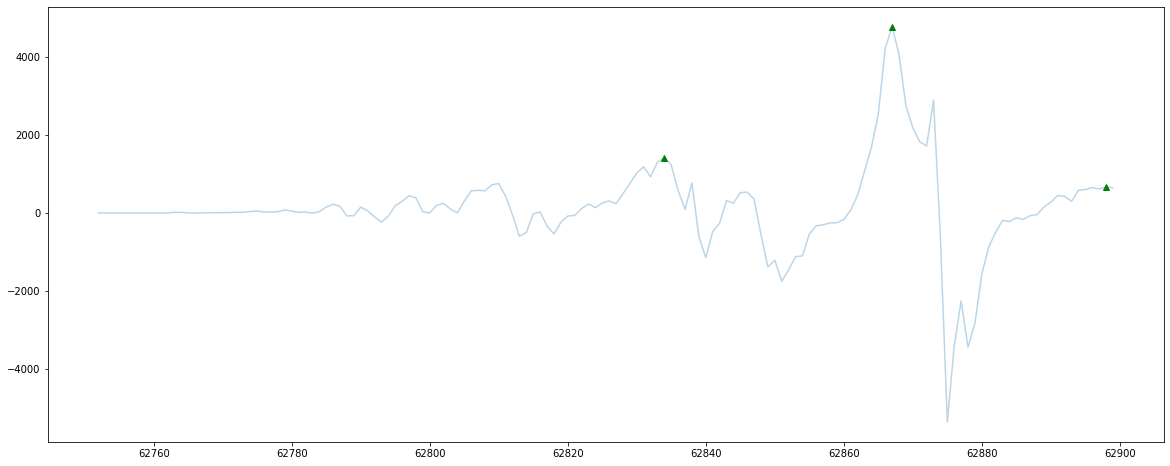

In [113]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak1.index(83)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

In [125]:
## this one returns nice values at least for most of the districts even with order =40 and no other complexity
## but I have some problems in only some districts that needs to be sorted_out

peak1=[]
peak2=[]
# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5) ::: it does not work and specially won't in case of weeks

# although it is not a good solution as it is not applicable to weeks 
# it is possible to choose more than three and then work out from there
for i in range(len(district_ids_from_cases)):
    time_series=np.array(week_df[week_df['districtid']==district_ids_from_cases[i]].cases)
    indices=signal.argrelextrema(time_series,np.greater_equal, order=40)[0]
    if len(indices)==2:
        peak1.append(indices[0]+1)
        peak2.append(indices[1]+1)
    else:
        if len(indices)<2:
            indices=signal.argrelextrema(time_series,np.greater_equal, order=30)[0]
            if len(indices)==2:
                peak1.append(indices[0]+1)
                peak2.append(indices[1]+1)
            else:
                if len(indices)<2:
                    indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
                    if len(indices)==2:
                        peak1.append(indices[0]+1)
                        peak2.append(indices[1]+1)
                    else:
                        indices=choose_function(time_series,indices)
                        peak1.append(indices[0]+1)
                        peak2.append(indices[1]+1)
                else:
                    indices=choose_function(time_series,indices)
                    peak1.append(indices[0]+1)
                    peak2.append(indices[1]+1)
        else:
            indices=choose_function(time_series,indices)
            peak1.append(indices[0]+1)
            peak2.append(indices[1]+1)

# 585 cases pass len==2 condition at fiirst go

In [92]:

peak2.index(2)

120

In [105]:
data_csv[data_csv['District']=='phek'].Confirmed.sum()

45969

In [98]:
district_ids_from_cases[peak1.index(124)]

'NL_Phek'

[  0   1   2   3  52  53 111]
[  0.   0.   0.   0. 451. 451. 250.]


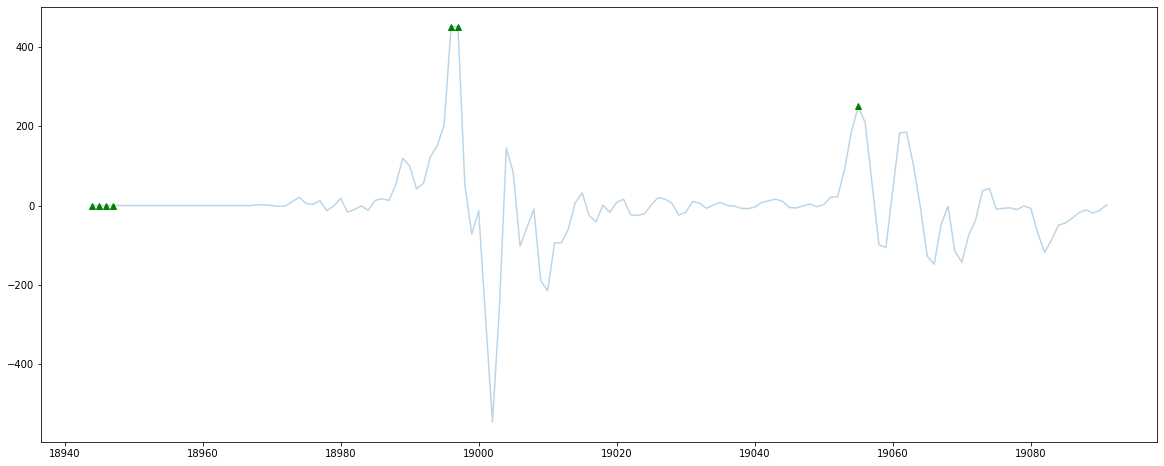

In [107]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(54)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[  0   1   2   3   4   5   6  28  33  34  56  58 139 144]
[ 0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  4.  4. 24. 24.]


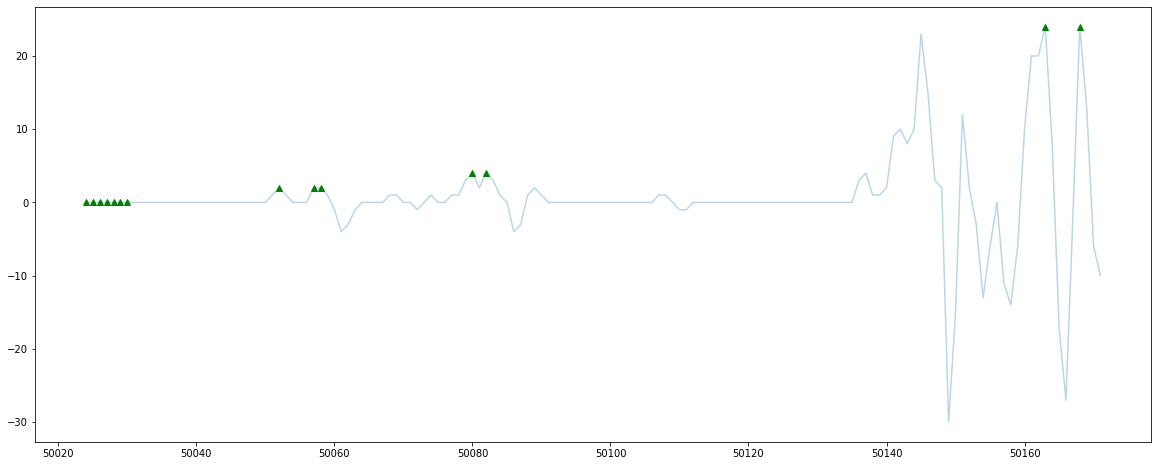

In [106]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak2.index(2)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[  0   1  38  69 123 124]
[ 0.  0.  9.  5. 56. 56.]


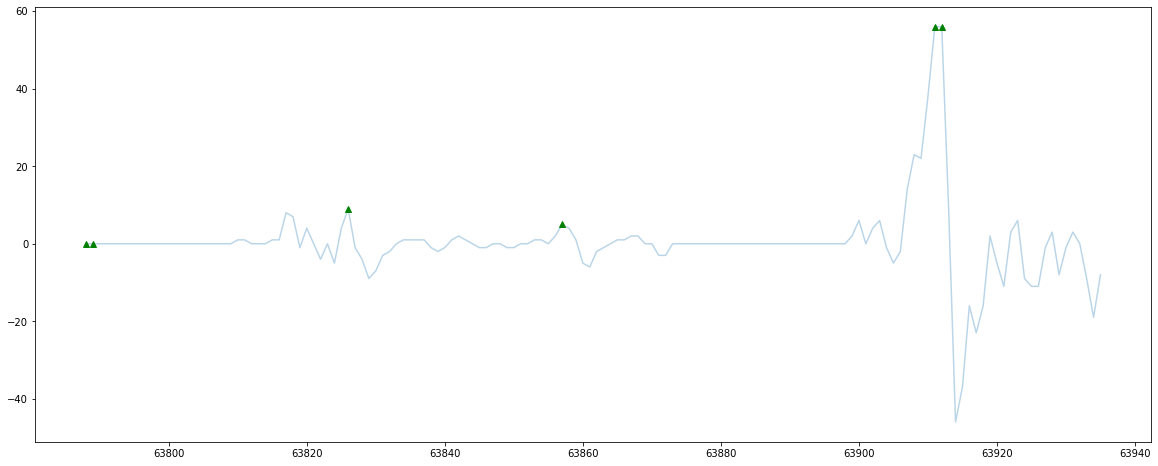

In [104]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[peak1.index(124)]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[ 12  48  72 113 144]
[ 477.  261.  182. 2462.    7.]


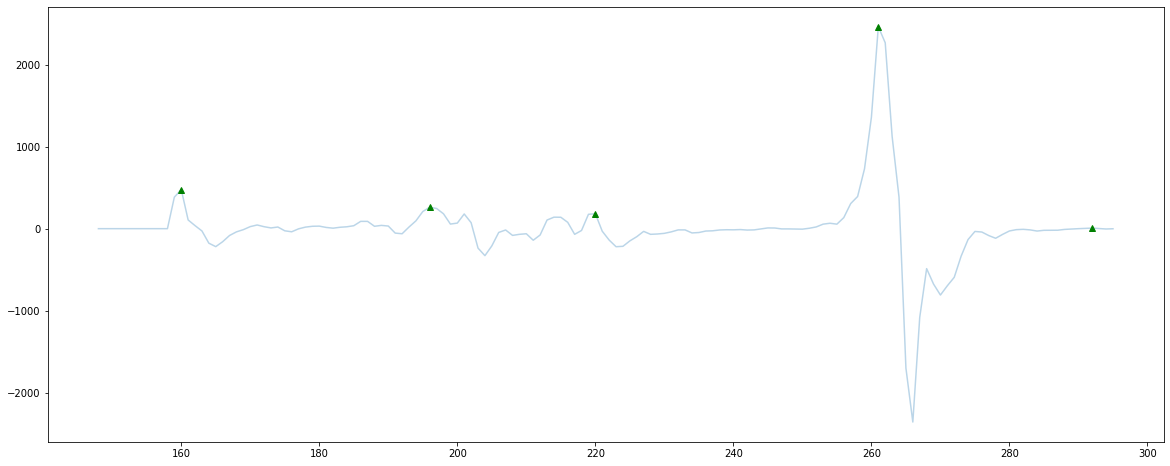

In [70]:
### test for any district  and also plot peaks
df=week_df[week_df['districtid']==district_ids_from_cases[1]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=20)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

[ 1  5 12]
[ 426.  511. 1146.]


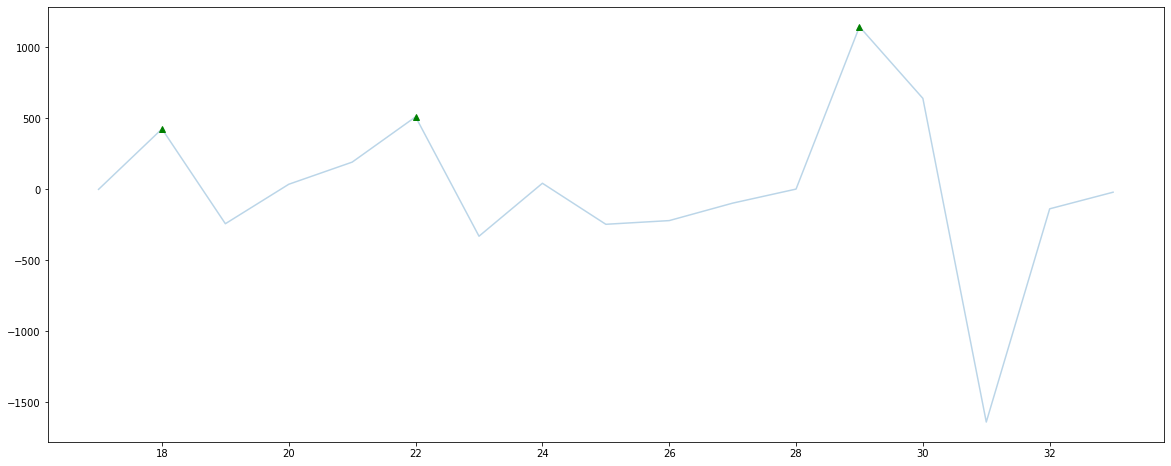

In [22]:
### test for any district  and also plot peaks
df=month_df[month_df['districtid']==district_ids_from_cases[1]]
time_series=np.array(df.cases)

indices=signal.argrelextrema(time_series,np.greater_equal, order=3)[0]
print(indices)

# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5)
print(time_series[indices])
# max two can be dones using no. cases in time series
df.cases.plot(figsize=(20,8), alpha=.3)
df.iloc[indices].cases.plot(style='.', lw=10, color='green', marker="^");
#df.iloc[ilocs_min].cases.plot(style='.', lw=10, color='green', marker="^");

In [24]:
peak1=[]
peak2=[]
# basically order three can insure at least 2 peaks and I have to pick 2 from them only max ones I guess
# month ID automatically becomes ''indices+1''
# I just can only try order 3,4(maybe 5) ::: it does not work and specially won't in case of weeks

# although it is not a good solution as it is not applicable to weeks 
# it is possible to choose more than three and then work out from there
for i in range(len(district_ids_from_cases)):
    time_series=np.array(month_df[month_df['districtid']==district_ids_from_cases[i]].cases)
    indices=signal.argrelextrema(time_series,np.greater_equal, order=4)[0]
    if len(indices)==2:
        peak1.append(indices[0]+1)
        peak2.append(indices[1]+1)
    else:
        if len(indices)<2:
            indices=signal.argrelextrema(time_series,np.greater_equal, order=3)[0]
            if len(indices)==2:
                peak1.append(indices[0]+1)
                peak2.append(indices[1]+1)
            else:
                if len(indices)<2:
                    indices=signal.argrelextrema(time_series,np.greater_equal, order=2)[0]
                    if len(indices)==2:
                        peak1.append(indices[0]+1)
                        peak2.append(indices[1]+1)
                    else:
                        indices=choose_function(time_series,indices)
                        peak1.append(indices[0]+1)
                        peak2.append(indices[1]+1)
                else:
                    indices=choose_function(time_series,indices)
                    peak1.append(indices[0]+1)
                    peak2.append(indices[1]+1)
        else:
            indices=choose_function(time_series,indices)
            peak1.append(indices[0]+1)
            peak2.append(indices[1]+1)

# 585 cases pass len==2 condition at fiirst go

## don't run last cell as that gives away variables to month cases